# **DEPENDENCE**

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil

import librosa
import soundfile

import random
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

import xgboost as xgb
from xgboost import XGBClassifier 
from xgboost import plot_tree


import multiprocessing
import threading

import time
import warnings
warnings.filterwarnings("ignore")

------
------
------

# **DATA PREPARE**

In [2]:
def extract_feature(wav_path):
    signal, sr = librosa.load(wav_path, sr=None)
#     signal = signal[int(0.3*sr):int(0.5*sr)]
    
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=20)
    spectral_contrast = librosa.feature.spectral_contrast(y=signal, sr=sr)
    spectral_centroid = librosa.feature.spectral_centroid(y=signal, sr=sr)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(signal)

    features = np.concatenate([mfcc.flatten(), 
                              spectral_contrast.flatten(), 
                              spectral_centroid.flatten(), 
                              zero_crossing_rate.flatten()])
    return features

In [3]:
def feature_prepare(DATA):
    wav_data = []
    wav_labels = []
    for root, _, wav_list in os.walk(DATA):
        if len(wav_list) != 0:
            random.shuffle(wav_list)
            random.shuffle(wav_list)

        for wav_name in tqdm(wav_list):
            if wav_name.endswith('.wav'):
                wav_path = os.path.join(root, wav_name)
                features = extract_feature(wav_path)
                wav_labels.append(0 if "NG" in wav_name else 1)
                wav_data.append(features)
    features_arr, targets = np.array(wav_data), np.array(wav_labels)

    encoder = LabelEncoder()
    targets_onehot = encoder.fit_transform(targets)
    return features_arr, targets_onehot

In [4]:
features_train, targets_train = feature_prepare("MECH-DATA/MECH-DATA/TRAIN")
features_test, targets_test = feature_prepare("MECH-DATA/MECH-DATA/TEST")

0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 282/282 [00:03<00:00, 90.49it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 441/441 [00:04<00:00, 89.16it/s]


------
------
------

# **TRAINING PROCESS**

In [5]:
result = {}
for step in tqdm(range(10)):
    X_train, X_test, y_train, y_test = train_test_split(features_train, targets_train, test_size=0.3, shuffle=True)
    
    # Initialize the model
    model = XGBClassifier(n_estimators=1000, learning_rate=0.05, eval_metric='mlogloss')
    
    # Train the model
    model.fit(X_train, y_train)

    # Predict mini - test from Train
    y_pred = model.predict(X_test)
    precision_mini = precision_score(y_test, y_pred)
    recall_mini = recall_score(y_test, y_pred)
    f1_mini = f1_score(y_test, y_pred)
    acc_mini = accuracy_score(y_test, y_pred)
    
    # Predict unseen - test
    y_pred = model.predict(features_test)
    precision_unseen = precision_score(targets_test, y_pred)
    recall_unseen = recall_score(targets_test, y_pred)
    f1_unseen = f1_score(targets_test, y_pred)
    acc_unsseen = accuracy_score(targets_test, y_pred)
    
    result[step] = {'model': model, 'accuracy_mini': acc_mini, 'accuracy_unseen': acc_unsseen,
                    'precision_mini': precision_mini, 'recall_mini': recall_mini, 'f1_mini': f1_mini,
                    'precision_unseen': precision_unseen, 'recall_unseen': recall_unseen, 'f1_unseen': f1_unseen}
    
print("Random Split Training Done!!!")

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [01:52<00:00, 11.25s/it]

Random Split Training Done!!!


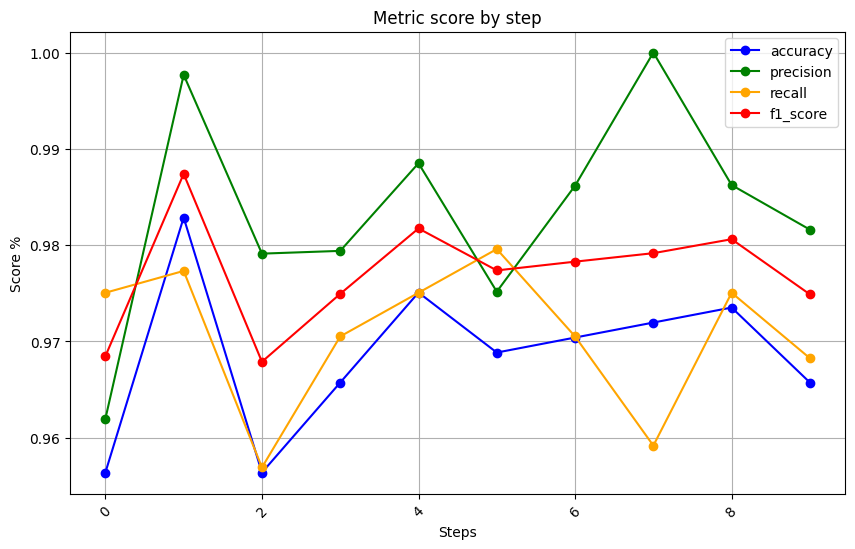

In [6]:
# Tạo danh sách các bước
steps = list(result.keys())

# # Tạo danh sách các giá trị accuracy
accuracy = [result[step]['accuracy_unseen'] for step in steps]

# Tạo danh sách các giá trị precision
precision = [result[step]['precision_unseen'] for step in steps]

# Tạo danh sách các giá trị recall
recall = [result[step]['recall_unseen'] for step in steps]

# Tạo danh sách các giá trị F1-score
f1_score = [result[step]['f1_unseen'] for step in steps]

# Trực quan hóa accuracy
plt.figure(figsize=(10, 6))
plt.title('Metric score by step')
plt.ylabel('Score %')
plt.xlabel('Steps')
plt.xticks(rotation=45)
plt.grid(True)


plt.plot(steps, accuracy, marker='o', color='blue', label='accuracy')
plt.plot(steps, precision, marker='o', color='green', label='precision')
plt.plot(steps, recall, marker='o', color='orange', label='recall')
plt.plot(steps, f1_score, marker='o', color='red', label='f1_score')
plt.legend()
plt.show()

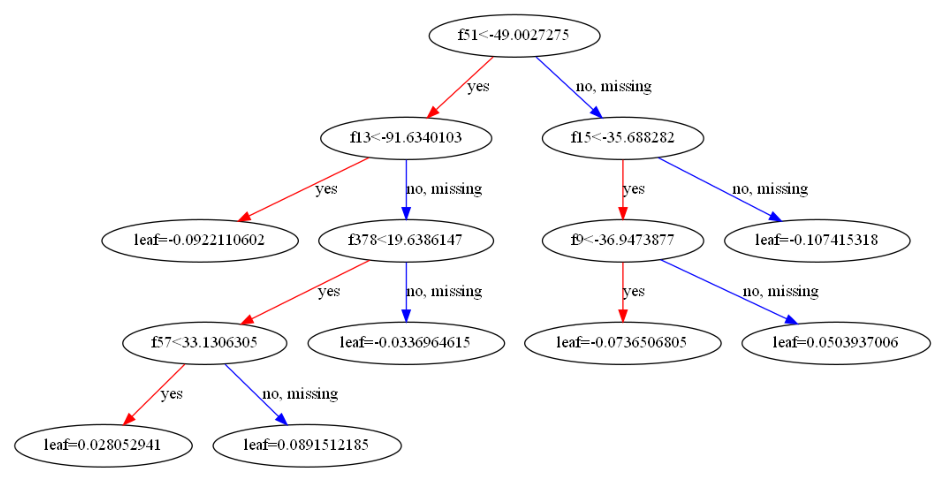

In [21]:
best_model = result[1]['model']
plot_tree(best_model)
plt.show()

------
------
------

# **MODEL EVAL**

In [8]:
scores = cross_val_score(best_model, X_train, y_train, cv=10)
for idx, scr in enumerate(scores):
    print(f"\nAccuracy Fold {idx}: {scr:.2f}")
    
print(f"\nAverage Accuracy: {np.mean(scores):.2f}")


Accuracy Fold 0: 0.97

Accuracy Fold 1: 0.97

Accuracy Fold 2: 0.97

Accuracy Fold 3: 0.97

Accuracy Fold 4: 1.00

Accuracy Fold 5: 1.00

Accuracy Fold 6: 0.97

Accuracy Fold 7: 0.94

Accuracy Fold 8: 1.00

Accuracy Fold 9: 0.97

Average Accuracy: 0.98


              precision    recall  f1-score   support

           0       0.95      1.00      0.97       201
           1       1.00      0.98      0.99       441

    accuracy                           0.98       642
   macro avg       0.98      0.99      0.98       642
weighted avg       0.98      0.98      0.98       642



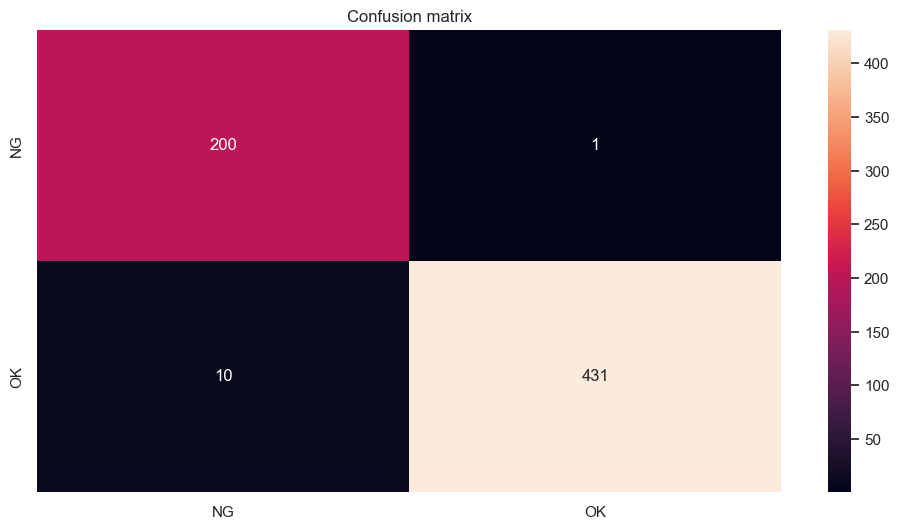

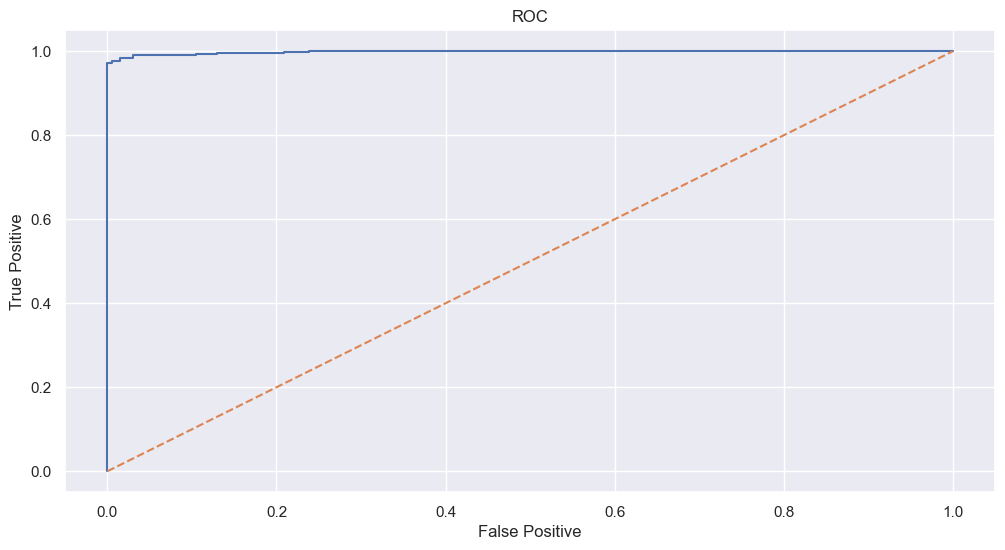

In [10]:
class_dic = {0: 'NG', 1: 'OK'}

y_pred = best_model.predict(features_test)
cf_matrix3 = confusion_matrix(targets_test, y_pred)
plt.title("Confusion matrix")
sns.set(rc={'figure.figsize': (12, 6)})
sns.heatmap(cf_matrix3, annot=True, fmt="d", xticklabels=class_dic.values(), yticklabels=class_dic.values())
print(classification_report(targets_test, y_pred))
plt.show()

y_pred_prob = best_model.predict_proba(features_test)
fpr, tpr, thresholds = roc_curve(targets_test, y_pred_prob[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC')
plt.show()

------
------
------
------
------
------

# **SAVE & LOAD & RE-TEST LOADED XGBOOST**

In [18]:
best_model.save_model("XGBoostModel.txt")
model_xgb = xgb.XGBClassifier()
model_xgb.load_model("XGBoostModel.txt")

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       201
           1       1.00      0.98      0.99       441

    accuracy                           0.98       642
   macro avg       0.98      0.99      0.98       642
weighted avg       0.98      0.98      0.98       642



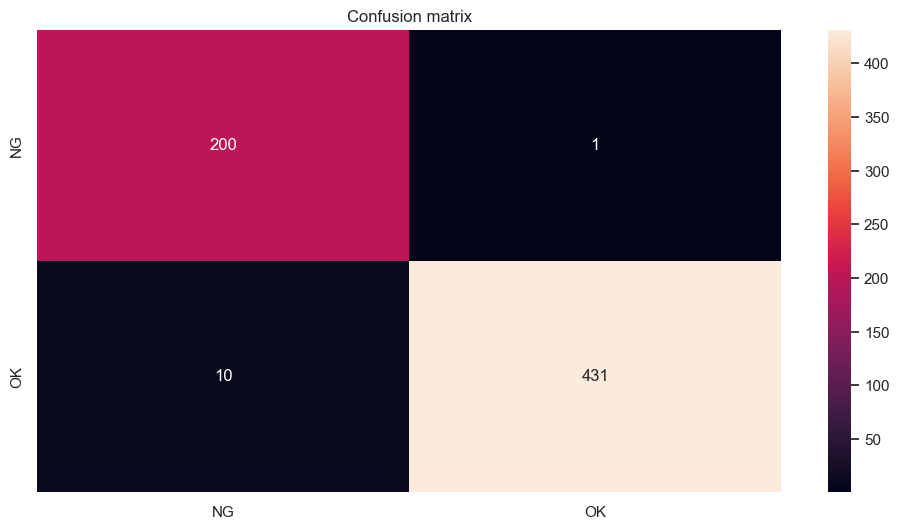

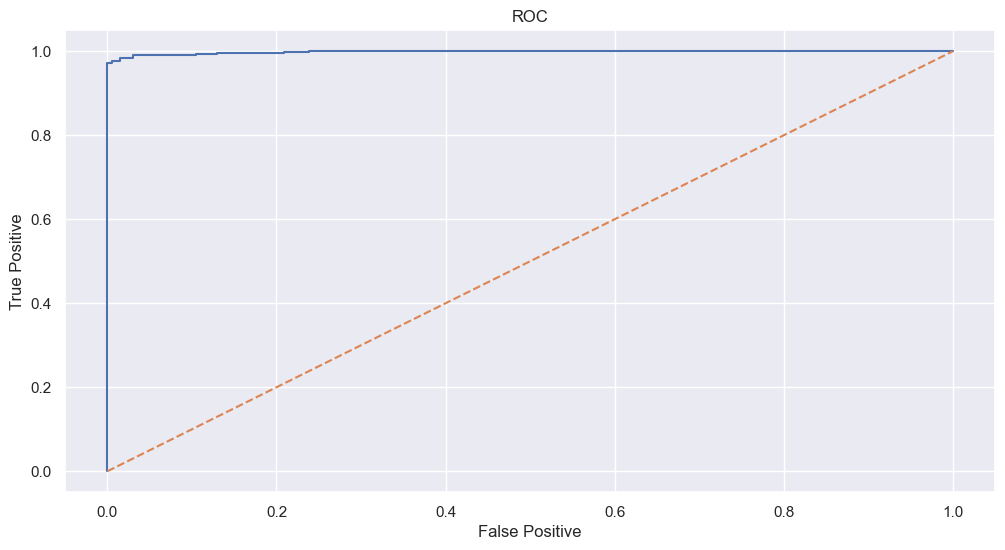

In [19]:
class_dic = {0: 'NG', 1: 'OK'}

y_pred = model_xgb.predict(features_test)
cf_matrix3 = confusion_matrix(targets_test, y_pred)
plt.title("Confusion matrix")
sns.set(rc={'figure.figsize': (12, 6)})
sns.heatmap(cf_matrix3, annot=True, fmt="d", xticklabels=class_dic.values(), yticklabels=class_dic.values())
print(classification_report(targets_test, y_pred))
plt.show()

y_pred_prob = model_xgb.predict_proba(features_test)
fpr, tpr, thresholds = roc_curve(targets_test, y_pred_prob[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC')
plt.show()

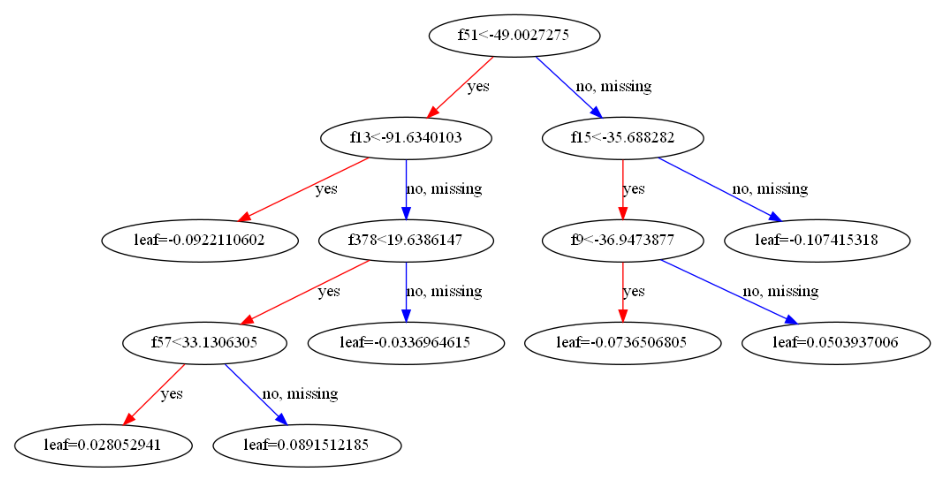

In [20]:
plot_tree(model_xgb)
plt.show()